In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import idct

In [6]:
# Function to get the inverse DCT
def idct2D(dctImg):
    tmp = idct(dctImg, type=2 ,norm='ortho').transpose()
    return idct(tmp, type=2 ,norm='ortho').transpose()

# Function to get the inverse zig-zag scan of the quantized DCT coefficients
def inverseZigzagScan(scan):
    img = np.zeros((8, 8), dtype=np.int16)
    hmin = 0
    wmin = 0
    hmax = 7
    wmax = 7
    h = hmin
    w = wmin
    i = 0
    while h <= hmax and w <= wmax:
        # Going up
        if (h + w) % 2 == 0:
            # Last column
            if w == wmax:
                img[h, w] = scan[i]
                h += 1
                i += 1
            # First row
            elif h == hmin:
                img[h, w] = scan[i]
                w += 1
                i += 1
            # Other cases
            else:
                img[h, w] = scan[i]
                h -= 1
                w += 1
                i += 1
        # Going down
        else:
            # Last row
            if h == hmax:
                img[h, w] = scan[i]
                w += 1
                i += 1
            # First column
            elif w == wmin:
                img[h, w] = scan[i]
                h += 1
                i += 1
            # Other cases
            else:
                img[h, w] = scan[i]
                h += 1
                w -= 1
                i += 1
    return img

# Function to get the quantization matrix according to the block size
def quantizationMatrix(blockSize, flag=0):
    # Defining the standard quantization matrix for JPEG compression
    # Luminance Quantization Table
    Q1 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])
    # Chrominance Quantization
    Q2 = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]])
    if blockSize == [8, 8]:
        if flag == 0:
            return Q1
        if flag == 1:
            return Q2
    pass


In [7]:
def jpeg_decode(img, blockSize, numberOfCoefficients, jpegCompressed, flag=0):
    # Height and width of the image
    h, w = img.shape
    
    # Size of each block
    a, b = blockSize
    size = a * b

    # Getting the quantized DCT coefficients by reversing the zigzag scan
    scan = np.zeros(size, dtype=np.int16)
    inverseZigzag = np.zeros((h//a, w//b, a, b), dtype=np.int16)
    for i in range(h//a):
        for j in range(w//b):
            for k in range(size):
                if k < numberOfCoefficients:
                    scan[k] = jpegCompressed[(i * w//b + j) * numberOfCoefficients + k]
                else:
                    scan[k] = 0
            inverseZigzag[i][j] = inverseZigzagScan(scan)

    # Dequantizing the DCT coefficients
    Q = quantizationMatrix(blockSize, flag)
    inverseQuantized = inverseZigzag * Q

    # Applying the inverse DCT to each 8x8 block
    inverseDCT = np.zeros((h//a, w//b, a, b), dtype=np.float16)
    for i in range(h//a):
        for j in range(w//b):
            inverseDCT[i][j] = idct2D(inverseQuantized[i][j])

    # Adding 128 to each pixel
    inverseDCT += 128

    decodedImg = np.zeros((h, w), dtype=np.uint8)
    for i in range(h//a):
        for j in range(w//b):
            decodedImg[i*a:(i+1)*a, j*b:(j+1)*b] = inverseDCT[i][j].astype(np.uint8)
    return decodedImg

RMSE:  9.727322236825215
PSNR:  28.370937549096794
Compression Ratio:  4.266666666666667


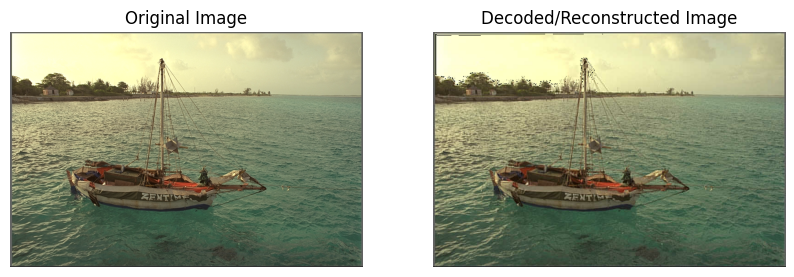

In [8]:
# filename = input("Enter the filename: ")
filename = "img.png"
# blockSize = input("Enter the block size: ")
blockSize = [8, 8]
# numberOfCoefficients = input("Enter the number of coefficients: ")
numberOfCoefficients = 15
# color = input("Enter the color space: ")
color = 1
# txtFile = input("Enter the name of the text file containing the jpeg encoded array: ")
txtFile = "img_jpegcode.txt"

file = open(txtFile, "r")
jpegCompressed = file.read().split()
file.close()

if color == 0:
    img = cv.imread(filename, 0)
    decodedImg = jpeg_decode(img, blockSize, numberOfCoefficients, jpegCompressed, 0)
    plt.figure(figsize=(10, 10))
    plt.subplot(121); plt.imshow(img, cmap='gray'); plt.title("Original Image"); plt.axis('off')
    plt.subplot(122); plt.imshow(decodedImg, cmap='gray'); plt.title("Decoded/Reconstructed Image"); plt.axis('off')

if color == 1:
    img = cv.imread(filename, 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.subplot(121); plt.imshow(img); plt.title("Original Image"); plt.axis('off')
    img = cv.cvtColor(img, cv.COLOR_RGB2YCR_CB)
    x = len(jpegCompressed)//3
    jpeg1 = jpegCompressed[:x]
    jpeg2 = jpegCompressed[x:2*x]
    jpeg3 = jpegCompressed[2*x:3*x]
    decodedY = jpeg_decode(img[:,:,0], blockSize, numberOfCoefficients, jpeg1, 0)
    decodedCr = jpeg_decode(img[:,:,1], blockSize, numberOfCoefficients, jpeg2, 1)
    decodedCb = jpeg_decode(img[:,:,2], blockSize, numberOfCoefficients, jpeg3, 1)
    decodedImg = np.dstack((decodedY, decodedCr, decodedCb))
    decodedImg = cv.cvtColor(decodedImg, cv.COLOR_YCR_CB2RGB)
    plt.subplot(122); plt.imshow(decodedImg); plt.title("Decoded/Reconstructed Image"); plt.axis('off')

RMSE = np.sqrt(np.mean((img - decodedImg) ** 2))
print("RMSE: ", RMSE)
PSNR = 20 * np.log10(255.0 / RMSE)
print("PSNR: ", PSNR)
compRatio = (img.size * 8) / (len(jpegCompressed) * 8)
print("Compression Ratio: ", compRatio)